In [1]:
from flygym.examples import cpg_controller
from pathlib import Path
import pickle
import math
import numpy as np
from tqdm import trange
from flygym.preprogrammed import all_leg_dofs
from flygym.util import get_data_path
from flygym import Fly, Camera, SingleFlySimulation
from flygym.arena import complex_terrain as ct
from flygym.arena import base as ba
from flygym.examples import obstacle_arena as oa
from flygym import preprogrammed as pp
import matplotlib.pyplot as plt
from flygym.preprogrammed import get_collision_geometries
from IPython.display import Video
import imageio
from dm_control.rl.control import PhysicsError


# Data Paths

In [2]:
save_dir = Path("outputs")
save_dir.mkdir(exist_ok=True) 

data_path = get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

In [3]:
run_time = 2
timestep = 1e-4
actuated_joints = all_leg_dofs

target_num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * timestep

for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[joint])

In [4]:
floor_contacts = get_collision_geometries("legs")
# floor_contacts += ["Head", "LPedicel", "LFuniculus", "RPedicel", "RFuniculus", "LArista", "RArista"]
floor_contacts += ["LArista", "RArista", "Head"]

In [5]:
floor_contacts

['LFCoxa',
 'LFFemur',
 'LFTibia',
 'LFTarsus1',
 'LFTarsus2',
 'LFTarsus3',
 'LFTarsus4',
 'LFTarsus5',
 'LMCoxa',
 'LMFemur',
 'LMTibia',
 'LMTarsus1',
 'LMTarsus2',
 'LMTarsus3',
 'LMTarsus4',
 'LMTarsus5',
 'LHCoxa',
 'LHFemur',
 'LHTibia',
 'LHTarsus1',
 'LHTarsus2',
 'LHTarsus3',
 'LHTarsus4',
 'LHTarsus5',
 'RFCoxa',
 'RFFemur',
 'RFTibia',
 'RFTarsus1',
 'RFTarsus2',
 'RFTarsus3',
 'RFTarsus4',
 'RFTarsus5',
 'RMCoxa',
 'RMFemur',
 'RMTibia',
 'RMTarsus1',
 'RMTarsus2',
 'RMTarsus3',
 'RMTarsus4',
 'RMTarsus5',
 'RHCoxa',
 'RHFemur',
 'RHTibia',
 'RHTarsus1',
 'RHTarsus2',
 'RHTarsus3',
 'RHTarsus4',
 'RHTarsus5',
 'LArista',
 'RArista',
 'Head']

In [6]:
# Initialize CPG network
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

cpg = cpg_controller.CPGNetwork(
        timestep=timestep,
        intrinsic_freqs=intrinsic_freqs,
        intrinsic_amps=intrinsic_amps,
        coupling_weights=coupling_weights,
        phase_biases=phase_biases,
        convergence_coefs=convergence_coefs,
    )

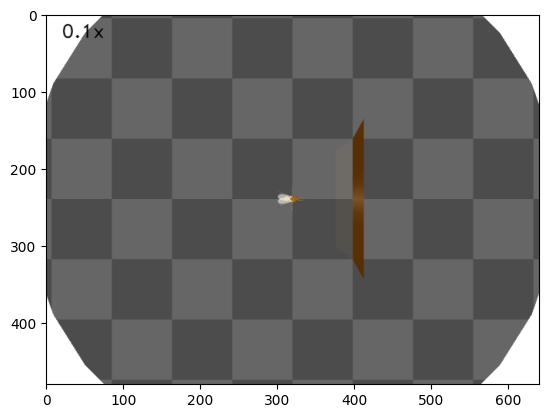

In [7]:
# Initialize fly
fly = Fly(
    spawn_pos=(0, 0, 0.5),
    actuated_joints=actuated_joints,
    contact_sensor_placements=["LArista", "RArista", "Head", "RFTarsus5", "LFTarsus5"],
    # enable_adhesion=True,
    # draw_adhesion=True,
    floor_collisions=floor_contacts,
)

# Initialize cameras
cameras = [
    Camera(fly=fly, camera_id=f"Animat/camera_{side}", window_size=(256, 256))
    for side in ["left", "right", "top", "front", "head_zoomin", "left_top_zoomout"]
]

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_front_zoomout_long",
    play_speed=0.1,
)

# Initialize simulation
arena = ba.ObstacleArenaGrp7()
arena2 = ba.FlatTerrain()

fly._define_observation_space(arena)

sim = SingleFlySimulation(
    fly=fly,
    cameras=cam,
    arena=arena,
)
# obs, info = sim.reset()

fly.change_segment_color(sim.physics, "LArista", (1, 0, 0, 0.5))

# with imageio.get_writer(save_dir / "multiview.mp4", fps=cameras[0].fps) as writer:
#     for i in trange(target_num_steps):
#         joint_pos = data_block[:, i]
#         action = {"joints": joint_pos}
#         obs, reward, terminated, truncated, info = sim.step(action)
#         images = sim.render()

#         if all(i is not None for i in images):
#             frame = np.concatenate(images, axis=1)
#             writer.append_data(frame)
images = sim.render()

# note that save_video is a method of Camera instead of Simulation
# cam.save_video(save_dir / "single_fly.mp4")

plt.imshow(images[0])


In [8]:
from flygym.examples.common import PreprogrammedSteps

preprogrammed_steps = PreprogrammedSteps()
# preprogrammed_steps._psi_funcs = *()

# Run simulation
obs_list = cpg_controller.run_cpg_simulation(sim, cpg, preprogrammed_steps, 1)

# Save video
cam.save_video(save_dir / "cpg_controller.mp4", 0)

100%|██████████| 10000/10000 [00:54<00:00, 185.07it/s]


In [9]:
# # in run_cpg_simulation function
# # out of loop 
# delay = 20

# #loop

# force_threshold = 0.1
# obs_list[1].keys()
# con_force_LArista = obs_list[0]["contact_forces"][0]
# con_force_RArista = obs_list[0]["contact_forces"][1]

# if (con_force_LArista > force_threshold or con_force_RArista > force_threshold):
#     print("Collision detected")
#     if (con_force_LArista > force_threshold):
#         nmf.fly.change_segment_color(sim.physics, "LArista", (1, 0, 0, 0.5))
#     if (con_force_RArista > force_threshold):
#         nmf.fly.change_segment_color(sim.physics, "RArista", (1, 0, 0, 0.5))
#     if (not backward_walking or (delay < 20 and delay > 0)):
#         delay -= 1
#         cpg_network.backward_walking = True
#         cpg_network.intrinsic_freqs *= -1 
# elif (cpg_network.backward_walking = True):
#     delay = 20
#     cpg_network.backward_walking = False
#     cpg_network.intrinsic_freqs *= -1
#     nmf.fly.change_segment_color(sim.physics, "LArista", (0, 0, 1, 0.5))
#     nmf.fly.change_segment_color(sim.physics, "RArista", (0, 0, 1, 0.5))
    

In [10]:
# if fly.Rantena_contact or fly.Lantena_contact:
#     print("Collision detected")
#     cpg_network.backward_walking = True

# if antenae_contact[0]>force_threshold:
#     print("Collision detected")
#     fly.Lantena_contact = True
# if antenae_contact[1]>force_threshold:
#     print("Collision detected")
#     fly.Rantena_contact = True


In [11]:
# print(obs_list['contact_forces'])

# antenae_contact = [obs['contact_forces'][0] , obs['contact_forces'][1]]
# print(antenae_contact)

# if antenae_contact[0] > 0.5 and antenae_contact[1] > 0.5:
#     fly.backward_walking(antenae_contact[0], antenae_contact[1])\
#     # fly.change_segment_color for when antenae are touched.
# else :
#     fly.forward_walking()

len(obs_list)

10000

In [12]:
obs_list[0].keys()

dict_keys(['joints', 'fly', 'contact_forces', 'end_effectors', 'fly_orientation'])

In [13]:
# # for all time steps of the simulation print the contact forces of right and left arista on the same plot, the x axis is the simulations steps
# # add a legend to the plot
# # add labels to the x and y axis
# # add a title to the plot
# plt.plot(obs_list[0]["contact_forces"][0])
# plt.plot(obs_list[0]["contact_forces"][1])
# plt.plot(obs_list[0]["contact_forces"][2])
# plt.legend(["Left Arista", "Right Arista", "LMTarsus5"])
# plt.xlabel("Simulation Steps")
# plt.ylabel("Contact Forces")
# plt.title("Contact Forces of Left and Right Arista")
# plt.show()



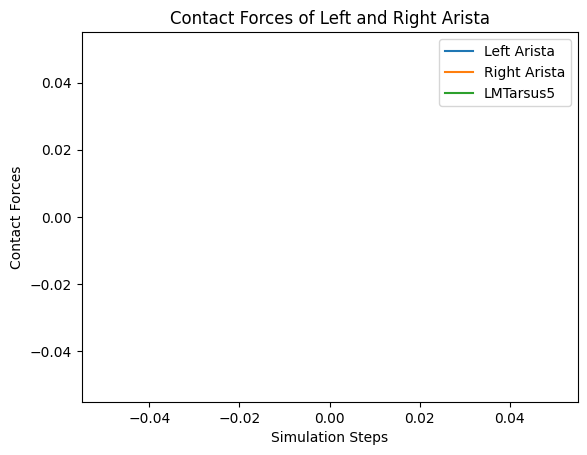

In [14]:
for i in range(len(obs_list)):
    plt.plot(obs_list[i]["contact_forces"][0][0])
    # plt.plot(obs_list[i]["contact_forces"][1])
    # plt.plot(obs_list[i]["contact_forces"][2])
    plt.legend(["Left Arista", "Right Arista", "LMTarsus5"])
    plt.xlabel("Simulation Steps")
    plt.ylabel("Contact Forces")
    plt.title("Contact Forces of Left and Right Arista")
plt.show()

In [15]:
# import matplotlib.pyplot as plt

# # Assuming obs_list is your list of observations from the simulation
# # and has the structure described.

# # Number of steps in the simulation
# num_steps = len(obs_list)

# # Create subplots
# fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

# # Titles for the subplots
# titles = ["Right Sensor - X Axis", "Right Sensor - Y Axis", "Right Sensor - Z Axis",
#           "Left Sensor - X Axis", "Left Sensor - Y Axis", "Left Sensor - Z Axis"]

# # Plot each contact force on the respective subplot
# for i in range(num_steps):
#     for j, sensor in enumerate(['right', 'left']):
#         for k, axis in enumerate(['x', 'y', 'z']):
#             index = j * 3 + k
#             axs[j, k].plot(obs_list[i]["contact_forces"][j][k], label=f'Step {i+1}')
#             axs[j, k].set_title(titles[index])
#             axs[j, k].set_xlabel('Time')
#             axs[j, k].set_ylabel('Force')

# # Adding a legend
# for ax in axs.flat:
#     ax.legend(loc='upper right')

# # Adjust layout for better spacing
# plt.tight_layout()

# # Save the figure
# plt.savefig('simulation_contact_forces.png', dpi=300)

# # Show the plot
# plt.show()

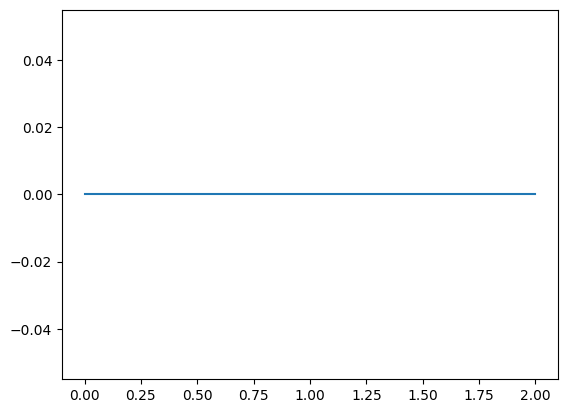

In [16]:
plt.plot(obs_list[9996]["contact_forces"][0])

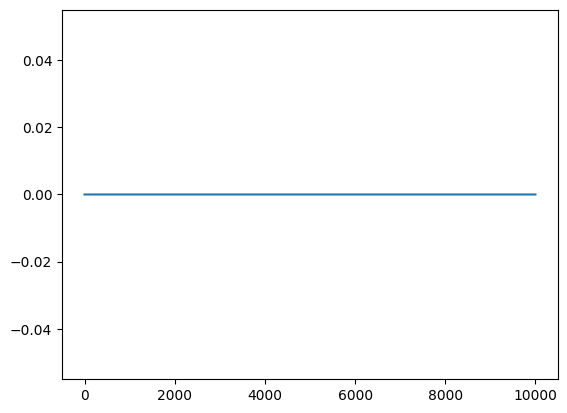

In [17]:
a =[]
for i in range(len(obs_list)):
    a.append(obs_list[i]["contact_forces"][2][0])
    if obs_list[i]["contact_forces"][2][0] != 0:
        print("Collision detected at step", i)
plt.plot(a)


In [18]:
obs_list[0]["contact_forces"]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)

In [19]:
type(cam)

flygym.camera.Camera

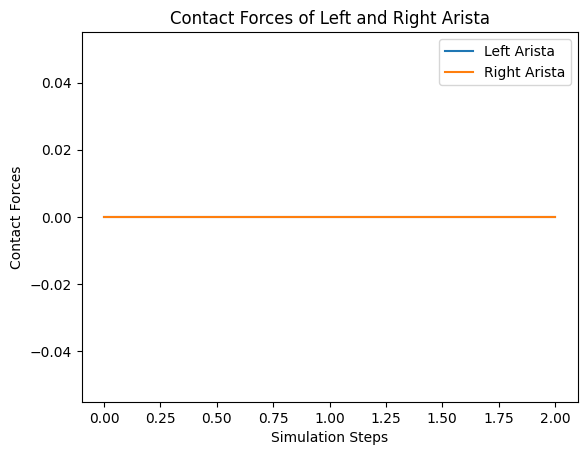

In [20]:
# plot the contact forces of the left arista and the right arista as a function of the time or the simulation steps
# add a legend to the plot
# add labels to the x and y axis
# add a title to the plot
plt.plot(obs_list[0]["contact_forces"][0])
plt.plot(obs_list[0]["contact_forces"][1])
plt.legend(["Left Arista", "Right Arista"])
plt.xlabel("Simulation Steps")
plt.ylabel("Contact Forces")
plt.title("Contact Forces of Left and Right Arista")
plt.show()

In [21]:
len(obs_list)
target_num_steps

20000

In [22]:
for key in fly._floor_contacts:
    if "micha" in key and "ground" in key:
        print(key)
        print(fly._floor_contacts[key])

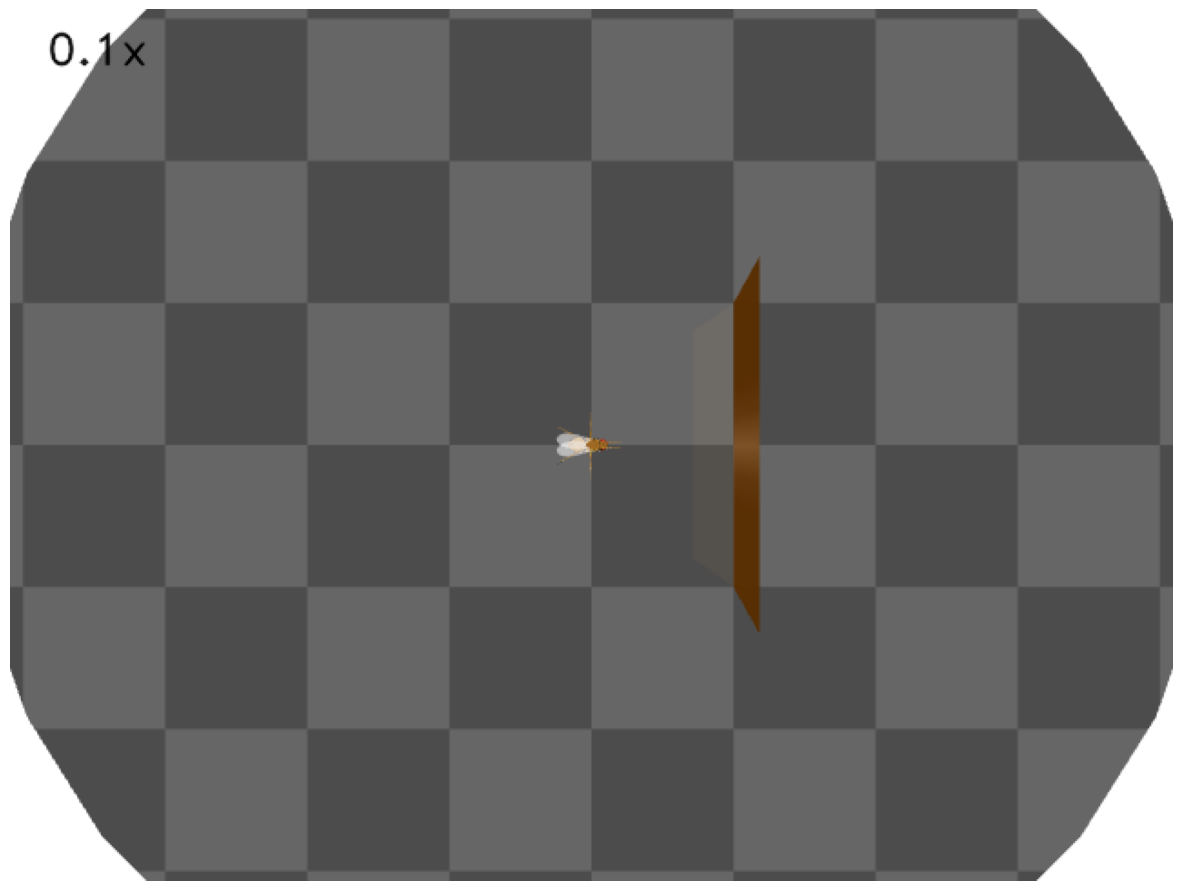

In [23]:

# Video(str(save_dir / "multiview.mp4"))

# plt.imshow(images[-1])
# show all cameras in a single big plot
plt.figure(figsize=(15, 15))
plt.imshow(np.concatenate(images, axis=1))
plt.axis("off")
plt.show()



# Video(str(save_dir / "single_fly.mp4"))
Video(str("./outputs/cpg_controller.mp4"))

cpg controller
turning controller
hybrid controller
rule based contoller

arena with correct obstacles

backward-walking and turning from paper implemented in all controllers
randomized froward walking from paper implemented in all controllers

antenae and mechanical contact sensors, use fly attributes for this.

actuate antenae and head.

convert recordings to preprogrammed steps.


In [24]:
fly.get_observation(sim)
# fly.change_segment_color for when antenae are touched.
# pp.get_collision_geometries()

{'joints': array([[ 8.64582807e-02,  6.42381191e-01,  7.90784508e-02,
         -1.83101463e+00,  6.11980200e-01,  1.29561901e+00,
         -8.46900582e-01,  1.09150909e-01,  1.77575862e+00,
          9.16038215e-01, -1.51643431e+00, -4.16716546e-01,
          2.02467918e+00, -6.90272927e-01,  6.68358803e-01,
          2.52192736e+00,  2.37246707e-01, -2.10811973e+00,
         -2.97185570e-01,  2.18401313e+00, -1.42470405e-01,
          2.87658215e-01, -1.08356094e+00, -2.24647205e-02,
         -2.27049041e+00, -9.02766168e-01,  2.03655195e+00,
         -7.37905562e-01, -7.79119730e-02, -1.90251720e+00,
         -8.58747184e-01, -1.21295166e+00, -8.30685496e-02,
          1.87256861e+00, -1.06565726e+00,  9.62136030e-01,
         -2.61447787e+00, -2.92701155e-01, -1.46540248e+00,
          2.86152512e-01,  1.32785678e+00,  4.04646844e-02],
        [-1.55351744e+01, -1.58810720e+01,  1.47848778e+01,
          3.53629646e+01,  1.45004530e+01, -2.10055141e+01,
         -2.21387119e+01, -1.